# NLP Lab 2

В данном ноутбуке описаны 4 различных эксперимента с Seq2Seq NLP моделями нацеленных на перевод с английского языка на русский язык. В качестве данных для тренировки/оценки качества используется зафиксированный набор данных ([data.txt](https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt)). Такой небольшой набор данных позволяет быстро получить результаты обучения и сравнить другие подходы на тех же данных. Разумеется, возможно использовать другие датасеты (e.g. [opus100-en-ru](https://huggingface.co/datasets/opus100)), но это требует значительных вычислительных ресурсов (gpu) и времени. 

В фиксированном датасете все примеры предложений завязаны на отельную тематику (описание услуг отелей) и во многом переиспользование ключевых слов (некоторые выражения не переводятся и остаются в обоих языках as is). Такое ограничение размера датасета и тематики приводит к тому, что модели неспособны переводить свободную речь даже при использовании предобученных embedding векторов слов (**fasttext/glove**).  

Пример запуска тренировки через kaggle - см. ноутбук `kaggle_example.ipynb`  

## Описание экспериментов

Целью моих экспериментов был прежде всего собственный интерес и получение практики написания кода подобных проектов. 

Все эксперименты имеют схожую структуру тренировки и оценки, приходится лишь заменять внутреннюю логику - объединение батчей, кодирование и декодирование последовательностей, перевод, инициализация конфигов. Однако эти замены на деле потребовали много времени и принесли много головной боли.

Для каждого из экспериментов приложен сопутствующий файл (%model_name%.zip), где лежат веса модели, tensorboard и мои логи обучения - графики построены оттуда же.

1) `rnn2rnn_without_attention.py`: RNN2RNN_wo_attention - классический rnn encoder -> rnn decoder без использования attention слоя.  
2) `rnn2rnn.py`: RNN2RNN - rnn encoder -> rnn decoder c использованием [Luong attention](https://arxiv.org/abs/1508.04025), код LuongAttention отчасти позаимствован [отсюда](https://github.com/kevinlu1211/pytorch-batch-luong-attention/blob/master/models/luong_attention/luong_attention.py) с исправлениями.  
3) `cnn2cnn.py`: CNN2CNN - cnn encoder -> cnn decoder; 5й ноутбук этого [репозитория](https://github.com/bentrevett/pytorch-seq2seq) .   
4) `bert2gpt.py`: pretrained BERT -> gpt2; Использование предобученного `bert-base-uncased` в купе с нуля обучаемой `gpt2`. Веса и архитектуры моделей позаимствовал у huggingface/transformers. Для gpt2 переиспользовал bpe tokenizer от `DeepPavlov/rubert-base-cased`, где `<BOS>` и `<EOS>` в понимании модели замещались `<CLS>` и `<SEP>` (поскольку они вставлялись на начало и конец последовательности). Натренировать **не получилось** - я не дождался ни одной эпохи, полагаю, что дело в моем коде - разберусь однажды.  


### Занимательные факты

- Использование pretrained векторов слов (fasttext) для rnn2rnn размеров 300 (embeedding_size) не привело к улучшению результата, возможно не хватало hidden_size. Обучение с нуля показало лучше результат.  
- Любые операции над тензорами (Torch 1.8.0) на MacOS (10.15.7) может приводить к рандомным SIGSEGV.  


## Данные

Объем файла `data.txt` - 50_000 пар en-ru.
- train size: 80% -> 40k pairs  
- eval size: 15% -> 7.5k pairs 
- test size (bleu scoring): 5% -> 2.5k pairs  

## Расчет времени

Расчет времени происходил на моем ноутбуке: 

- torch==1.8.1+cpu  
- torchtext==0.9.0  
- nltk==3.6.2  
- spacy == 3.0.6

![pc-stats](./imgs/pc-stats.jpg)

### Логи

1) Чтобы посмотреть логи tensroboard детальнее, вы можете воспользоваться следующей командой:  
`tensorboard --logdir experiments/rnn/nlp-lab2-2/exp_RNN2RNN/` - обратите внимание на пути в каждом из экспериментов  
2) Чтобы посмотреть логи приложения, следует открыть файл `experiments/rnn/runner.log`  

In [20]:
from IPython.display import SVG, display
def show_svg(path):
    display(SVG(url=path))
    
local_path = !pwd
local_path = local_path[0]

## RNN2RNN w/o attention

- GRU  
- bidirectional encoder, standard decoder  
- 2 layers encoder and decoder
- hidden_size: 512  
- embedding_size: 256  
- layer_dropout: 0.25  
- dropout: 0.25  

1) Model RNN2RNN_wo_attention computes sequence `[batch_size: 32, en_seq_lenth: 45, ru_seq_length: 50]` within `0.73608` seconds.  
2) Model RNN2RNN_wo_attention has `[18695212]` parameters

- 20 эпох; batch_size: 128    
- Тренировка заняла ~22 минут  
- Около ~66 секунд на эпоху. 
- BLEU score: **23.59**  

Неудачные переводы:  
- Translation `Translation [This swimming pool is so huge` === `дом для отпуска с кухней находится в большом здании в гостевом доме в .`
- Translation `A room in budapest hotel has 3 toilets` === `гостевой дом & & большом здании бывшей резиденции , в здании бывшей водяной здании , в о .`

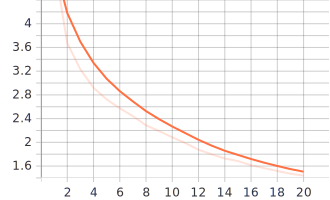

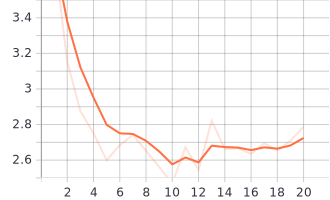

In [18]:
train_loss = f'file://{local_path}/imgs/rnn_wo_train_loss.svg'
val_loss = f'file://{local_path}/imgs/rnn_wo_val_loss.svg'


show_svg(train_loss)
show_svg(val_loss)

## RNN2RNN

- 20 эпох; batch_size: 128    
- Тренировка заняла ~30 минут  
- Около ~90 секунд на эпоху. 
- BLEU score: **26.88**  

1) Model RNN2RNN computes sequence `[batch_size: 32, en_seq_lenth: 45, ru_seq_length: 50]` within `0.88610` seconds.  
2) Model RNN2RNN has `[20080249]` parameters  

Неудачные переводы:  
- Translation `This swimming pool is so huge` === `с 600 600 лет с .`
- Translation `A room in budapest hotel has 3 toilets` === `от отеля ' до до ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '`

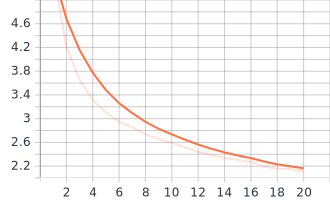

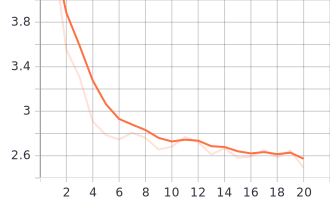

In [21]:
train_loss = f'file://{local_path}/imgs/rnn_train_loss.svg'
val_loss = f'file://{local_path}/imgs/rnn_val_loss.svg'


show_svg(train_loss)
show_svg(val_loss)

## CNN2CNN

- embedding_size: 256
- kernel size: 3
- nlayers: 10 for both encoder & decoder  
- hidden_size: 512  
- layer_dropout: 0.25  

1) Model CNN2CNN computes sequence `[batch_size: 32, en_seq_lenth: 45, ru_seq_length: 50]` within `1.43905` seconds.  
2) Model CNN2CNN has `[38905142]` parameters  

- 20 эпох; batch_size: 128   
- Тренировка заняла ~82 минут  
- Около ~246 секунд на эпоху. 
- BLEU score: **30.76**  
- BLEU может быть немного неверным из-за моей реализации перевода для этой архитектуры, поэтому **пометка с оговоркой**.

Неудачные переводы:  
- Translation `This swimming pool is so huge` === `отель h i s s s s s s s s o s s s s s s s s s`  
- Translation `A room in budapest hotel has 3 toilets` === `отель типа « постель и завтрак » r o .`  

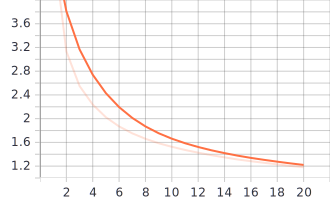

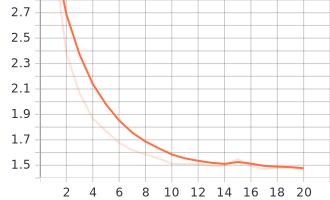

In [22]:
train_loss = f'file://{local_path}/imgs/cnn_train_loss.svg'
val_loss = f'file://{local_path}/imgs/cnn_val_loss.svg'


show_svg(train_loss)
show_svg(val_loss)

## Word Transformer

1) Model WORD_TRANSFORMER computes sequence `[batch_size: 32, en_seq_lenth: 45, ru_seq_length: 50]` within `0.26434` seconds.  
2) Model WORD_TRANSFORMER has `[11617418]` parameters   

- 20 эпох; batch_size: 128   
- Тренировка заняла ~82 минут  
- Около ~246 секунд на эпоху. 
- BLEU score: **30.76**  
- BLEU может быть немного неверным из-за моей реализации перевода для этой архитектуры, поэтому **пометка с оговоркой**.

Неудачные переводы:  
- Translation `This swimming pool is so huge` === `отель h i s s s s s s s s o s s s s s s s s s`  
- Translation `A room in budapest hotel has 3 toilets` === `отель типа « постель и завтрак » r o .`  